In [1]:
%matplotlib inline
from bs4 import BeautifulSoup
import requests
import pandas as pd
import lifelines
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
import seaborn as sns
sns.set(style="whitegrid", color_codes=True)

In [2]:
df_boston = pd.read_csv('Crime_Incident_Reports.csv')

C:\Users\Keshav\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:2902: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
len(df_boston)

268056

In [4]:
df_boston.columns

Index([u'COMPNOS', u'NatureCode', u'INCIDENT_TYPE_DESCRIPTION',
       u'MAIN_CRIMECODE', u'REPTDISTRICT', u'REPORTINGAREA', u'FROMDATE',
       u'WEAPONTYPE', u'Shooting', u'DOMESTIC', u'SHIFT', u'Year', u'Month',
       u'DAY_WEEK', u'UCRPART', u'X', u'Y', u'STREETNAME', u'XSTREETNAME',
       u'Location'],
      dtype='object')

In [5]:
df_boston.columns = [u'compnos', u'naturecode', u'incident_type_description',
       u'main_crimecode', u'reptdistrict', u'reporting_area', u'from_date',
       u'weapon_type', u'shooting', u'domestic', u'shift_incident', u'year', u'month',
       u'day_week', u'ucrpart', u'x', u'y', u'streetname', u'xstreetname',
       u'location']

In [6]:
df_boston.head(2)

,compnos,naturecode,incident_type_description,main_crimecode,reptdistrict,reporting_area,from_date,weapon_type,shooting,domestic,shift_incident,year,month,day_week,ucrpart,x,y,streetname,xstreetname,location
0,120420285,BERPTA,RESIDENTIAL BURGLARY,05RB,D4,629,07/08/2012 06:00:00 AM,Other,No,No,Last,2012,7,Sunday,Part One,763273.1791,2951498.962,ABERDEEN ST,NaN,"(42.34638135, -71.10379454)"
1,120419202,PSHOT,AGGRAVATED ASSAULT,04xx,B2,327,07/08/2012 06:03:00 AM,Firearm,Yes,No,Last,2012,7,Sunday,Part One,771223.1638,2940772.099,HOWARD AV,NaN,"(42.31684135, -71.07458456)"


In [7]:
# convert from_Date to date and time
list_times = list()
list_dates = list()
for row in df_boston.from_date:
    list_dates.append(row.split(' ',1)[0])
    list_times.append(row.split(' ',1)[1])
df_boston['dates'] = pd.Series(list_dates)
df_boston['times'] = pd.Series(list_times)

In [9]:
list_hours = list()
for row in df_boston.times:
    if 'AM' in row:
        list_hours.append(int(row.split(':',1)[0]))
    else:
        list_hours.append(int(row.split(':',1)[0]) + 12 )
df_boston['hours'] = pd.Series(list_hours)

In [10]:
df_boston.columns

Index([                  u'compnos',                u'naturecode',
       u'incident_type_description',            u'main_crimecode',
                    u'reptdistrict',            u'reporting_area',
                       u'from_date',               u'weapon_type',
                        u'shooting',                  u'domestic',
                  u'shift_incident',                      u'year',
                           u'month',                  u'day_week',
                         u'ucrpart',                         u'x',
                               u'y',                u'streetname',
                     u'xstreetname',                  u'location',
                           u'dates',                     u'times',
                           u'hours'],
      dtype='object')

In [40]:
list_crimes = list()
for row in df_boston.incident_type_description:
    list_crimes.append(row.upper())

In [41]:
df_boston['crime_category'] = pd.Series(list_crimes)

In [42]:
df_boston.crime_category.value_counts()

VAL                                 27363
OTHER LARCENY                       24443
SIMPLE ASSAULT                      18334
MEDASSIST                           17128
VANDALISM                           13968
MVACC                               13832
LARCENY FROM MOTOR VEHICLE          13265
INVPER                              12937
DRUG CHARGES                        12042
FRAUD                                8929
PROPLOST                             8522
TOWED                                7856
RESIDENTIAL BURGLARY                 7119
INVPROP                              6592
AGGRAVATED ASSAULT                   6008
SERVICE                              5353
ROBBERY                              5193
AUTO THEFT                           4851
PERSLOC                              4745
PROPFOUND                            4316
ARGUE                                2833
OTHER                                2599
ARREST                               1959
FIRE                              

In [24]:
list_crimes = list(set(list_crimes))
import difflib
for index,word in enumerate(list_crimes):
    print word,':',difflib.get_close_matches(word, list_crimes[index+1:],20)

LABOR : ['HARBOR', 'LANDLORD']
EMBEZZLEMENT : ['EMBEZELLMENT']
EVADING FARE : []
HOMICIDE : []
POLICE SERVICE INCIDENTS : ['PRISONER RELATED INCIDENTS', 'LICENSE PLATE RELATED INCIDENTS']
PROPERTY FOUND : ['PROPFOUND', 'PROPERTY LOST']
AUTO THEFT RECOVERY : ['AUTO THEFT']
DEATH INVESTIGATION : ['INVESTIGATE PERSON']
GAMBLING OFFENSE : []
BALLIST : ['BALLISTICS']
HARBOR RELATED INCIDENTS : ['PRISONER RELATED INCIDENTS', 'LICENSE PLATE RELATED INCIDENTS']
MANSLAUG : []
INVPROP : ['INVPER', 'BENOPROP']
TRESPASS : []
MEDASSIST : ['MEDICAL ASSISTANCE']
MISSING PERSON LOCATED : ['MISSING PERSON REPORTED']
SEX OFFENDER REGISTRATION : []
HARBOR : []
FIREARM DISCOVERY : []
GATHER : ['OTHER']
LIQUOR VIOLATION : ['DRUG VIOLATION', 'LICENSE VIOLATION', 'FIREARM VIOLATIONS', 'VIOLATIONS']
HATECRIM : []
PLATES : []
EMBEZELLMENT : []
DISORDERLY CONDUCT : ['DISORDERLY']
SIMPLE ASSAULT : ['INDECENT ASSAULT']
PRISONER RELATED INCIDENTS : ['LICENSE PLATE RELATED INCIDENTS', 'PROPERTY RELATED DAMAGE', 'FI

In [43]:
list_crimes_category = list_crimes

In [44]:
crimes_recategorized_list = list()
for category in list_crimes_category:
    if 'EMBEZ' in category:
        crimes_recategorized_list.append('EMBEZZLEMENT')
    elif 'INCIDENTS' in category:
        crimes_recategorized_list.append('INCIDENTS')
    elif 'PROP' in category:
        crimes_recategorized_list.append('PROPERTY')
    elif 'AUTO' in category:
        crimes_recategorized_list.append('AUTO')
    elif 'INVESTIGAT'in category:
        crimes_recategorized_list.append('INVESTIGATION')
    elif 'BALLIST' in category:
        crimes_recategorized_list.append('BALLISTICS')
    elif 'MED' in category:
        crimes_recategorized_list.append('MEDICAL ASSISTANCE')
    elif 'MISSING' in category:
        crimes_recategorized_list.append('MISSING PERSON')
    elif 'VIOLAT' in category:
        crimes_recategorized_list.append('VIOLATIONS')
    elif 'DISORDERLY' in category:
        crimes_recategorized_list.append('DISORDERLY CONDUCT')
    elif 'ASSAULT' in category:
        crimes_recategorized_list.append('ASSAULTS')
    elif 'PROST' in category:
        crimes_recategorized_list.append('PROSTITUTION')
    elif 'BURG' in category:
        crimes_recategorized_list.append('BURGLARY')
    elif 'WAR' in category:
        crimes_recategorized_list.append('WARRANTS')
    elif 'DRUG' in category:
        crimes_recategorized_list.append('DRUG')
    elif 'INFLUENCE' in category:
        crimes_recategorized_list.append('INFLUENCE')
    elif 'CHILD' in category:
        crimes_recategorized_list.append('CHILD-RELATED')
    elif 'LARC' in category:
        crimes_recategorized_list.append('LARCENY')
    elif 'BOMB' in category:
        crimes_recategorized_list.append('BOMB')
    else:
        crimes_recategorized_list.append(category)

In [46]:
len(crimes_recategorized_list)

268056

In [47]:
crimes_category = pd.Series(crimes_recategorized_list)

In [48]:
df_boston.crime_category = crimes_category

In [49]:
df_boston.crime_category.value_counts()

LARCENY                            38996
VAL                                27363
ASSAULTS                           24376
PROPERTY                           23375
MEDICAL ASSISTANCE                 17837
VANDALISM                          13968
MVACC                              13832
INVPER                             12937
DRUG                               12042
FRAUD                               8929
BURGLARY                            8743
TOWED                               7856
SERVICE                             5353
ROBBERY                             5193
AUTO                                4880
PERSLOC                             4745
ARGUE                               2833
OTHER                               2599
DISORDERLY CONDUCT                  1985
ARREST                              1959
FIRE                                1848
INVESTIGATION                       1737
VIOLATIONS                          1588
PHONECALLS                          1525
MOTOR VEHICLE AC

In [64]:
df_boston.crime_category.value_counts()[:20]

LARCENY               38996
VAL                   27363
ASSAULTS              24376
PROPERTY              23375
MEDICAL ASSISTANCE    17837
VANDALISM             13968
MVACC                 13832
INVPER                12937
DRUG                  12042
FRAUD                  8929
BURGLARY               8743
TOWED                  7856
SERVICE                5353
ROBBERY                5193
AUTO                   4880
PERSLOC                4745
ARGUE                  2833
OTHER                  2599
DISORDERLY CONDUCT     1985
ARREST                 1959
Name: crime_category, dtype: int64

In [67]:
df_boston.reptdistrict.value_counts().index

Index([u'B2', u'D4', u'C11', u'A1', u'B3', u'C6', u'D14', u'E13', u'E18',
       u'A7', u'E5', u'A15', u'HTU'],
      dtype='object')

In [190]:
distict_code_name_map = {
'A1' : 'Downtown','A15' : 'Charlestown','A7' :'East Boston',
'B2' : 'Roxbury',
'B3' : 'Mattapan',
'C6' : 'South Boston',
'C11' : 'Dorchester',
'D4' : 'South End',
'D14' : 'Brighton',
'E5' :'West Roxbury',
'E13' : 'Jamaica Plain',
'E18': 'Hyde Park',
'HTU': 'Human Traffic Unit'
}

In [70]:
df_boston = df_boston[pd.notnull(df_boston['reptdistrict'])]

In [191]:
list_districts = list()
for district in df_boston.reptdistrict:
    list_districts.append(distict_code_name_map[district])

In [72]:
df_boston['district'] = pd.Series(list_districts)

In [73]:
df_boston.district.value_counts()

Roxbury               40581
South End             37862
Dorchester            34553
Downtown              29621
Mattapan              24784
South Boston          20738
Brighton              19502
Jamaica Plain         15150
Hyde Park             13965
East Boston           12768
West Roxbury          12212
Charlestown            5612
Human Traffic Unit        8
Name: district, dtype: int64

In [74]:
df_boston.columns

Index([                  u'compnos',                u'naturecode',
       u'incident_type_description',            u'main_crimecode',
                    u'reptdistrict',            u'reporting_area',
                       u'from_date',               u'weapon_type',
                        u'shooting',                  u'domestic',
                  u'shift_incident',                      u'year',
                           u'month',                  u'day_week',
                         u'ucrpart',                         u'x',
                               u'y',                u'streetname',
                     u'xstreetname',                  u'location',
                           u'dates',                     u'times',
                           u'hours',            u'crime_category',
                        u'district'],
      dtype='object')

In [76]:
df_boston = df_boston.drop(['compnos','naturecode'],1)

In [78]:
df_boston.columns

Index([u'incident_type_description',            u'main_crimecode',
                    u'reptdistrict',            u'reporting_area',
                       u'from_date',               u'weapon_type',
                        u'shooting',                  u'domestic',
                  u'shift_incident',                      u'year',
                           u'month',                  u'day_week',
                         u'ucrpart',                         u'x',
                               u'y',                u'streetname',
                     u'xstreetname',                  u'location',
                           u'dates',                     u'times',
                           u'hours',            u'crime_category',
                        u'district'],
      dtype='object')

In [79]:
df_boston = df_boston.drop('reporting_area',1)

In [80]:
df_boston.columns

Index([u'incident_type_description',            u'main_crimecode',
                    u'reptdistrict',                 u'from_date',
                     u'weapon_type',                  u'shooting',
                        u'domestic',            u'shift_incident',
                            u'year',                     u'month',
                        u'day_week',                   u'ucrpart',
                               u'x',                         u'y',
                      u'streetname',               u'xstreetname',
                        u'location',                     u'dates',
                           u'times',                     u'hours',
                  u'crime_category',                  u'district'],
      dtype='object')

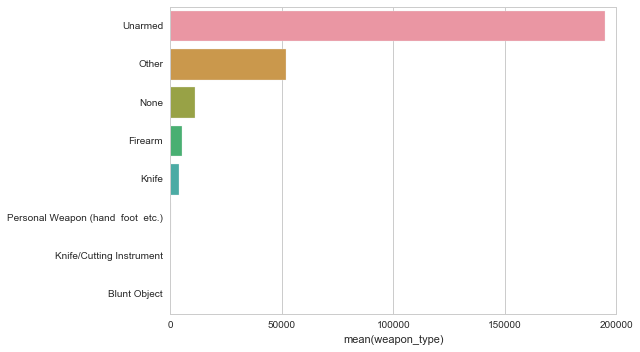

In [83]:
sns.barplot(y= df_boston.weapon_type.value_counts().index, x = df_boston.weapon_type.value_counts())

Most of the crime incidents occur without the use of weapons - most seem to be unarmed incidents.

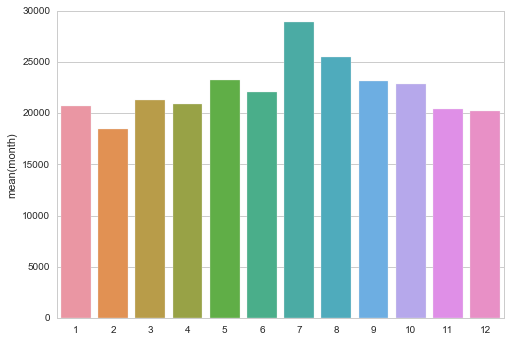

In [84]:
sns.barplot(x = df_boston.month.value_counts().index, y = df_boston.month.value_counts())

The incidents seem to reach a peak during the month of July and has a low during February. This could be attributed to the seasonal influence. It seems logical that less people will be out during the cold months (which notice a relative dip in attacks) when compared to the rest of the months. The climate patterns thus correlates with the above distribution.

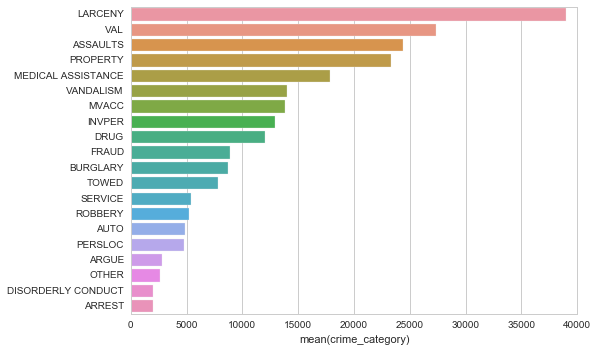

In [88]:
sns.barplot(y = df_boston.crime_category.value_counts()[:20].index, x = df_boston.crime_category.value_counts()[:20])

Larceny seems to be the most common crime which has occured.

In [90]:
sum(df_boston.crime_category.value_counts()[:10])/float(len(df_boston))

0.72295376523632882

More than 72% of the crimes are accounted by the top 10 crimes. It is better for the police to concentrate their policing more
on these crimes and work towards controlling them.

#### Crime Distribution month-wise

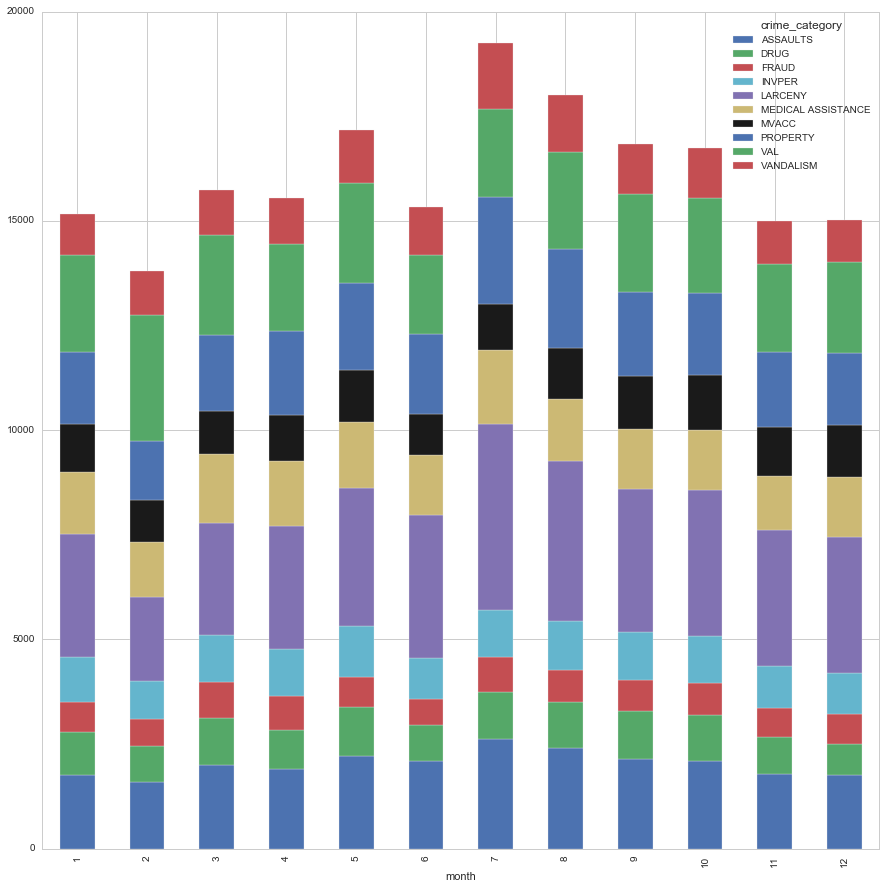

In [94]:
df_crime=pd.DataFrame(df_boston.crime_category.value_counts())
df_crime_head = pd.Series(df_crime.head(10).index)
df_crime_head_10 = df_boston[df_boston['crime_category'].isin(df_crime_head)]

tmp=pd.DataFrame(df_crime_head_10.groupby(['month','crime_category']).size(), columns=['count'])
tmp.reset_index(inplace=True)
tmp=tmp.pivot(index='month',columns='crime_category',values='count')
fig, axes = plt.subplots(1,1,figsize=(15,15))
tmp.plot(ax=axes,kind='bar', stacked=True)

The crimes seem to have an uniform distribution over the months. 

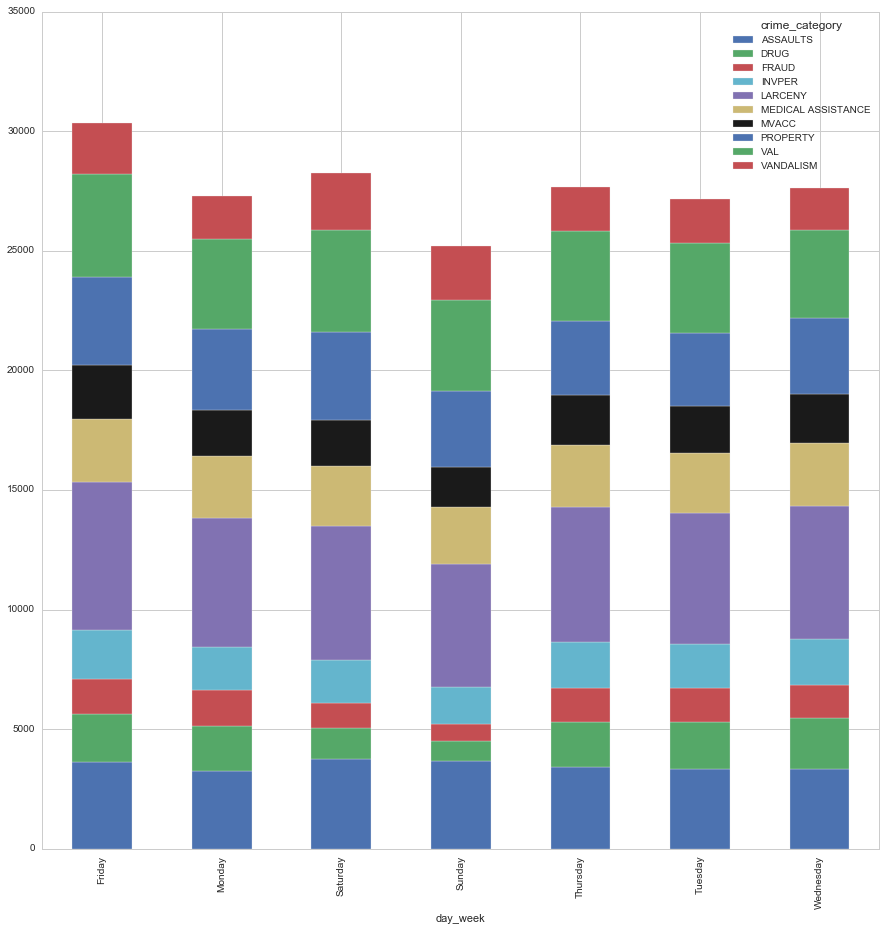

In [95]:
df_crime=pd.DataFrame(df_boston.crime_category.value_counts())
df_crime_head = pd.Series(df_crime.head(10).index)
df_crime_head_10 = df_boston[df_boston['crime_category'].isin(df_crime_head)]

tmp=pd.DataFrame(df_crime_head_10.groupby(['day_week','crime_category']).size(), columns=['count'])
tmp.reset_index(inplace=True)
tmp=tmp.pivot(index='day_week',columns='crime_category',values='count')
fig, axes = plt.subplots(1,1,figsize=(15,15))
tmp.plot(ax=axes,kind='bar', stacked=True)

Friday registers the most number of crimes while the least amount of incidents take place on Sunday. The proportion of crimes seem to be the same.

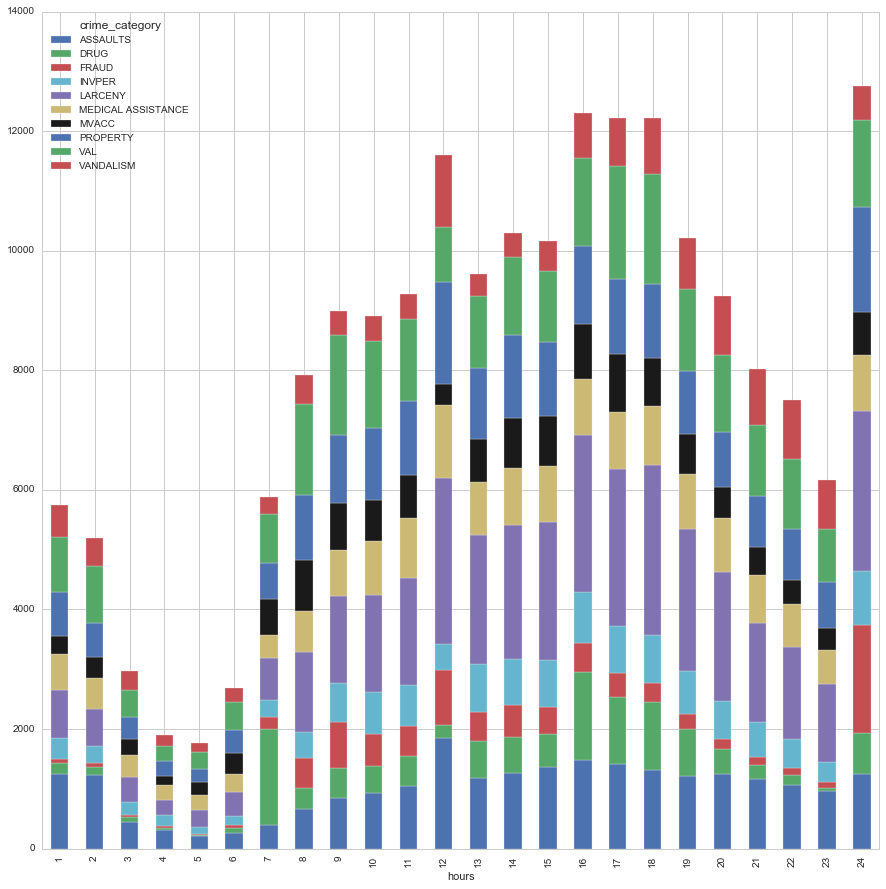

In [98]:
df_crime=pd.DataFrame(df_boston.crime_category.value_counts())
df_crime_head = pd.Series(df_crime.head(10).index)
df_crime_head_10 = df_boston[df_boston['crime_category'].isin(df_crime_head)]

tmp=pd.DataFrame(df_crime_head_10.groupby(['hours','crime_category']).size(), columns=['count'])
tmp.reset_index(inplace=True)
tmp=tmp.pivot(index='hours',columns='crime_category',values='count')
fig, axes = plt.subplots(1,1,figsize=(15,15))
tmp.plot(ax=axes,kind='bar', stacked=True)

The major peaks of this distribution occur during the hours 16-18 and during the 12th and 24th hours. The times entered
for a large part of crimes seem to be a rough estimate - 12 AM/PM seem to be an easy default option - this could be a reason behind the abnormally large peaks of the 12th and 24th hours - especially subsequent hours for each;the 13th and 1st hours seem to differ by a large amount.
Also, the 16-18 hours are the rush peak hours in Boston as the day gets over - the large rush of people in the public transport(The T). The largest proportion of crimes seem to be that of Larceny - not surprising since there is a good chance of them happening while travelling during the commotion/large crowds.

In [152]:
df_evening_hours = df_boston.query('hours == 16 or hours == 17 or hours == 18')
df_evening_weekday = df_evening_hours.query('day_week != "Saturday" and day_week!= "Sunday"')
df_evening_weekday_larceny = df_evening_weekday.query('crime_category == "LARCENY"')
df_evening_weekday_larceny_count = pd.DataFrame(df_evening_weekday_larceny.groupby('day_week')['crime_category'].count())

In [153]:
df_evening_hours = df_boston.query('hours == 16 or hours == 17 or hours == 18')
df_evening_weekend = df_evening_hours.query('day_week == "Saturday" or day_week== "Sunday"')
df_evening_weekend_larceny = df_evening_weekend.query('crime_category == "LARCENY"')
df_evening_weekend_larceny_count = pd.DataFrame(df_evening_weekend_larceny.groupby('day_week')['crime_category'].count())

In [154]:
df_evening_weekend_larceny_count['day_type'] = ['Weekend'] * 2
df_evening_weekday_larceny_count['day_type'] = ['Weekday'] * 5
df_larceny_weekday_weekend = df_evening_weekend_larceny_count.append(df_evening_weekday_larceny_count)

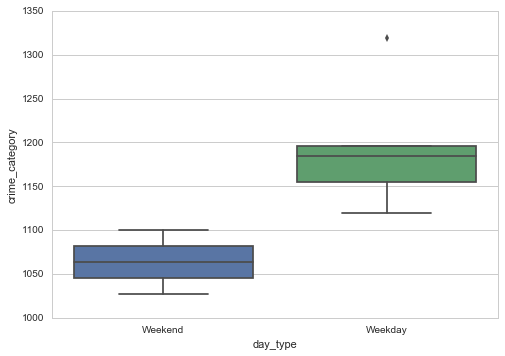

In [156]:
sns.boxplot(df_larceny_weekday_weekend.crime_category, groupby=df_larceny_weekday_weekend['day_type'])

In [157]:
from scipy.stats import ttest_ind
weekday = df_larceny_weekday_weekend.query('day_type == "Weekday"')
weekend = df_larceny_weekday_weekend.query('day_type == "Weekend"')
ttest_ind(weekday['crime_category'], weekend['crime_category'])

Ttest_indResult(statistic=2.1967637250229219, pvalue=0.079416953322189204)

On account of the boxplots shown and the t-tests done,there seems to be a reasonable evidence that the count of larceny 
incidents are influenced by a weekday or weekend.

The police can increase patrolling during the evening weekdays and take some measures to reduce the rate of larceny incidents.

In [162]:
#### Districts

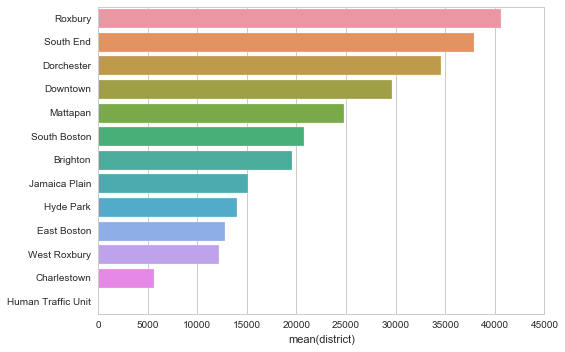

In [159]:
sns.barplot(y = df_boston.district.value_counts()[:20].index, x = df_boston.district.value_counts()[:20])

Roxbury seems to be the district with the maximum number of crime incidents, while Charlestown seems to have less prone to crime
incidents.
More focus can be given to the districts on the upper end of the distribution.

#### Range of dataset

In [176]:
from datetime import datetime
list_date_objects = list()
for date in df_boston.dates:
    list_date_objects.append(datetime.strptime(date, '%m/%d/%Y'))

In [178]:
min(list_date_objects)

datetime.datetime(2012, 7, 8, 0, 0)

In [179]:
max(list_date_objects)

datetime.datetime(2015, 8, 10, 0, 0)

The dataset has been collected from 8 July 2012 to 10 August 2015 - for a period of 3 years.

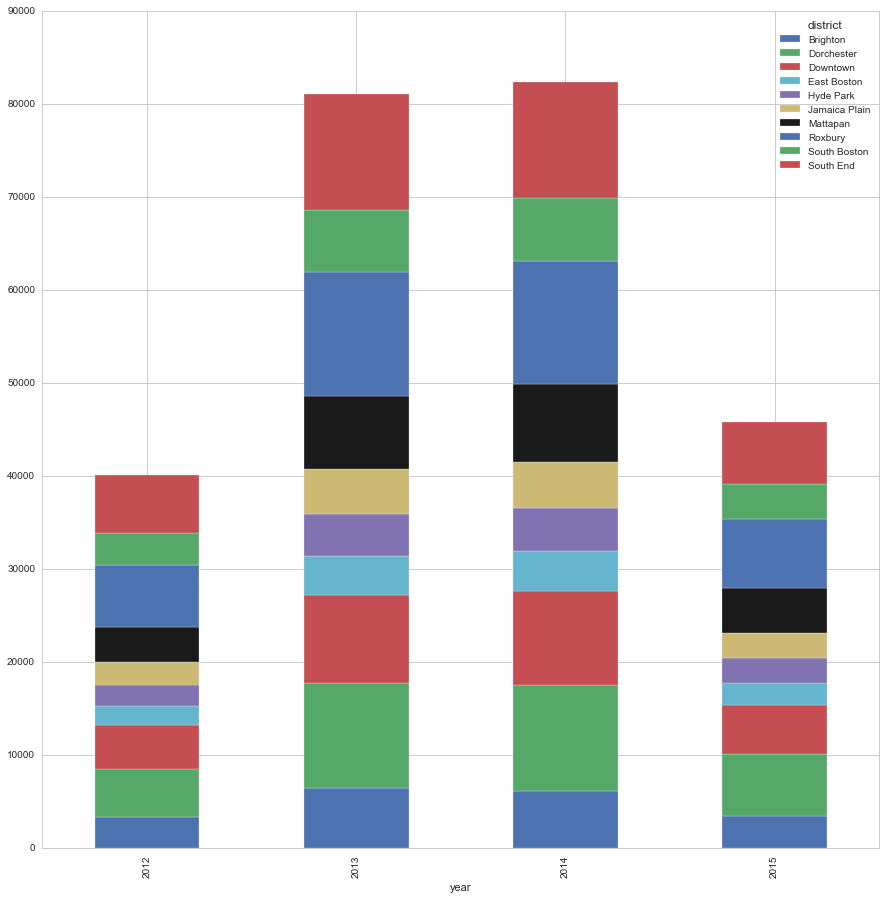

In [180]:
df_crime=pd.DataFrame(df_boston.district.value_counts())
df_crime_head = pd.Series(df_crime.head(10).index)
df_crime_head_10 = df_boston[df_boston['district'].isin(df_crime_head)]

tmp=pd.DataFrame(df_crime_head_10.groupby(['year','district']).size(), columns=['count'])
tmp.reset_index(inplace=True)
tmp=tmp.pivot(index='year',columns='district',values='count')
fig, axes = plt.subplots(1,1,figsize=(15,15))
tmp.plot(ax=axes,kind='bar', stacked=True)

2012 and 2015 are not represented completely in this dataset - 2013 and 2014 are. The distribution of crimes in districts from 2013 to 2014 seem constant.

#### Shooting

In [182]:
df_boston.shooting.value_counts()

No     267003
Yes       696
Name: shooting, dtype: int64

There seem to be a very less number of shooting incidents that have been registered over the last 3 years.

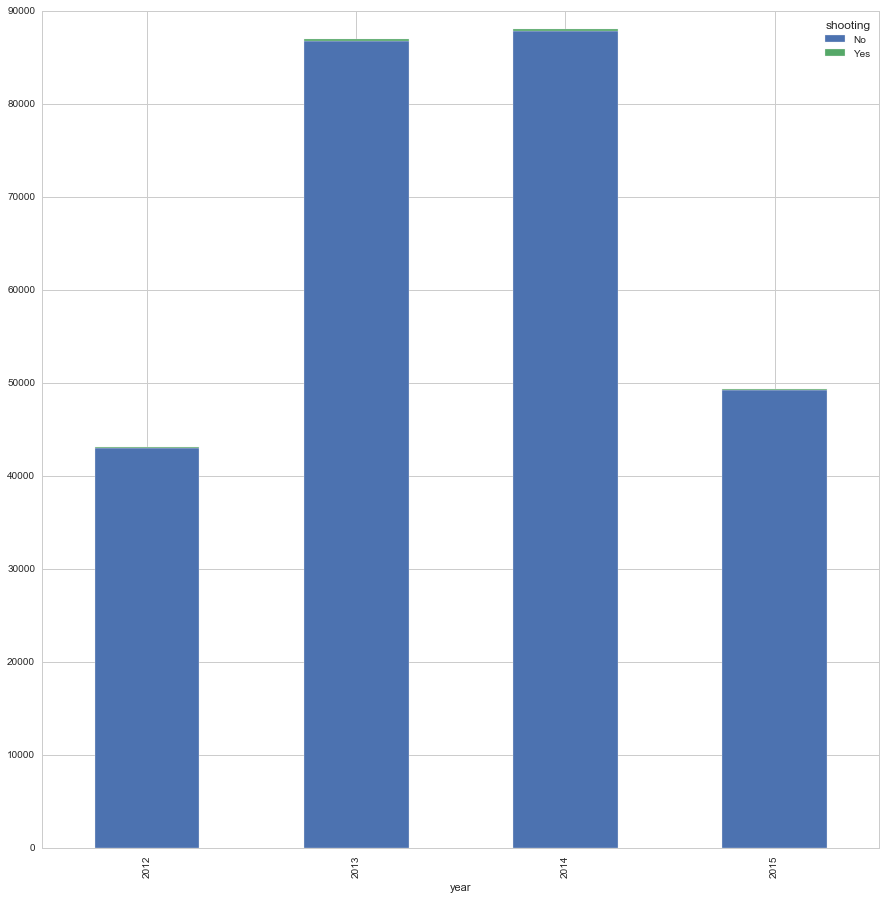

In [186]:
tmp=pd.DataFrame(df_boston.groupby(['year','shooting']).size(), columns=['count'])
tmp.reset_index(inplace=True)
tmp=tmp.pivot(index='year',columns='shooting',values='count')
fig, axes = plt.subplots(1,1,figsize=(15,15))
tmp.plot(ax=axes,kind='bar', stacked=True)

The shooting related incidents seem to be have a constant rate over the period.

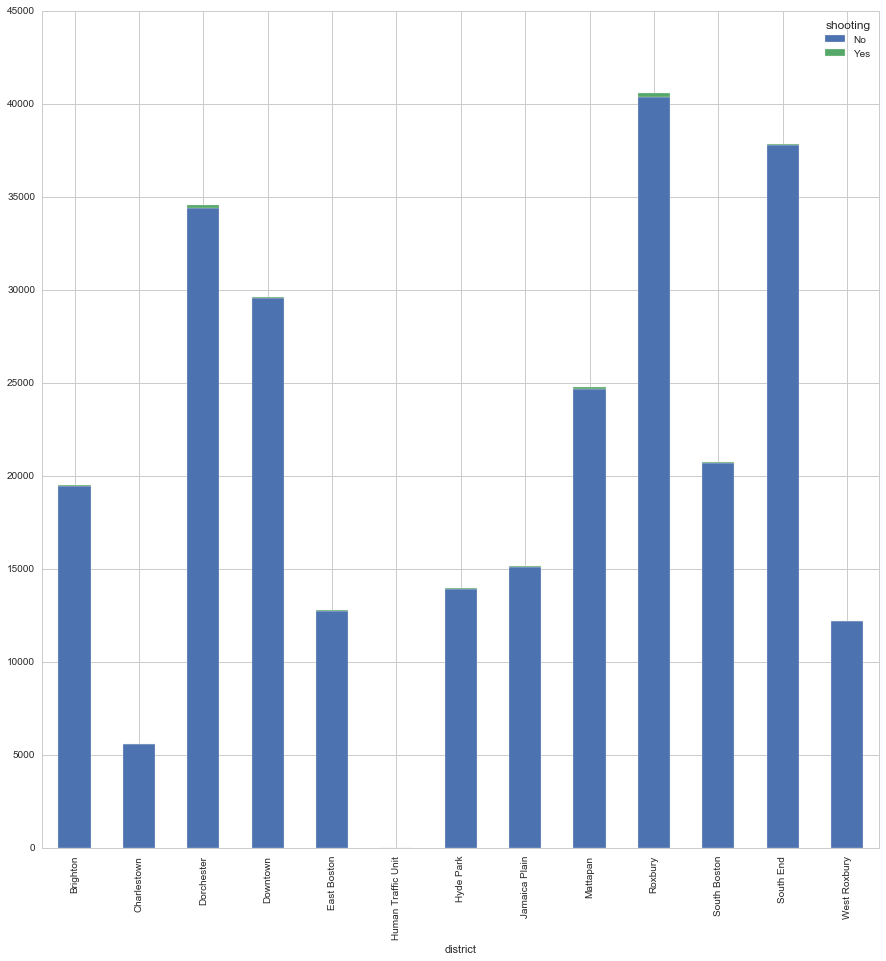

In [196]:
tmp=pd.DataFrame(df_boston.groupby(['district','shooting']).size(), columns=['count'])
tmp.reset_index(inplace=True)
tmp=tmp.pivot(index='district',columns='shooting',values='count')
fig, axes = plt.subplots(1,1,figsize=(15,15))
tmp.plot(ax=axes,kind='bar', stacked=True)

Rochester seems to have the highest shooting incidents - which is not surprising.

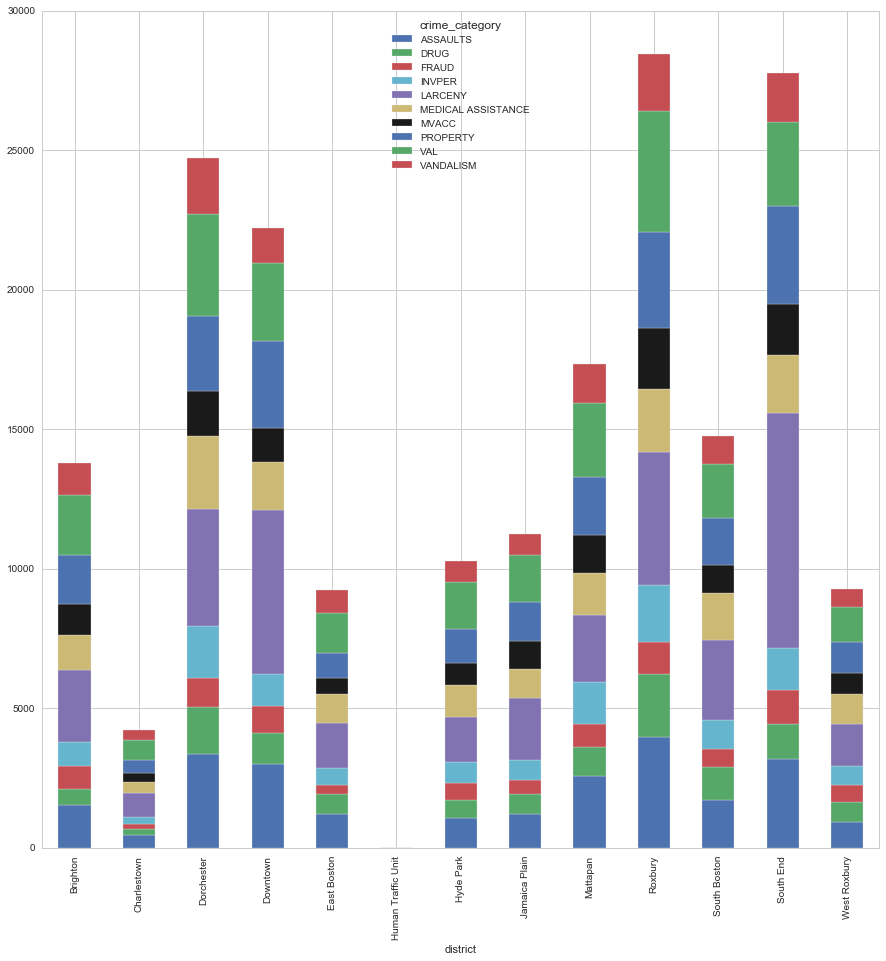

In [197]:
df_crime=pd.DataFrame(df_boston.crime_category.value_counts())
df_crime_head = pd.Series(df_crime.head(10).index)
df_crime_head_10 = df_boston[df_boston['crime_category'].isin(df_crime_head)]

tmp=pd.DataFrame(df_crime_head_10.groupby(['district','crime_category']).size(), columns=['count'])
tmp.reset_index(inplace=True)
tmp=tmp.pivot(index='district',columns='crime_category',values='count')
fig, axes = plt.subplots(1,1,figsize=(15,15))
tmp.plot(ax=axes,kind='bar', stacked=True)

* There seems to be a high proportion of Larceny-incidents in the case of South End - The South End has two most frequented T stop- Prudential and Copley which could contribute to the high larceny incidents apart from the high amount of tourists and vehicles in this area.
* The drug related incidents seem to have their maximum count in Roxbury while assualt related incidents are represented by Dorchester, Roxbury, Downtown and South End the most.
* VAL-related incidents have their max count in Roxbury.

#### Street-wise distribution

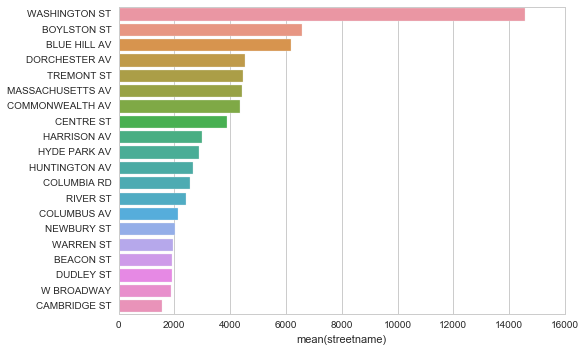

In [198]:
sns.barplot(y = df_boston.streetname.value_counts()[:20].index, x = df_boston.streetname.value_counts()[:20])

Washington Street seems to be the street where a large proportion of crimes have occured, followed by Boylston Street and 
Blue Hill Ave. 

In [199]:
df_washington_st = df_boston.query('streetname == "WASHINGTON ST"')

In [200]:
df_washington_st.district.value_counts()

Roxbury          3021
Downtown         2107
Dorchester       2004
South End        1638
Brighton         1358
Jamaica Plain    1343
West Roxbury     1314
Mattapan          545
South Boston      423
Hyde Park         355
East Boston       274
Charlestown       152
Name: district, dtype: int64

### To quote Wikipedia:
* There are multiple Washington Streets situated in Boston - One of them is the longest street in Boston 
originating in downtown Boston, Massachusetts that extends southwestward to the Massachusetts-Rhode Island state line. 
* There are other two significant and two minor streets in Boston with the same name.
In the Dorchester neighborhood, Washington Street extends approximately 2.8 miles (4.5 km) from Blue Hill Avenue near Geneva Avenue to Dorchester Avenue at the southern boundary of the city.
- In Allston-Brighton, Washington Street begins at the boundary with Brookline and extends about 2 miles (3.2 km) to the boundary with Newton near Burton Street. As a whole, it begins in Brookline Village, and crosses Brookline, Allston, Brighton, Newton, and Wellesley, ending at Wellesley's boundary with Natick, a total of almost 13.5 miles (21.7 km). It is the main east-west street in Brighton.
- In Hyde Park, Washington Street extends approximately seven blocks in the small portion of Hyde Park on the east side of the Neponset River.
- In Charlestown, Washington Street begins at a dead end near the intersection of Austin Street and New Rutherford Avenue and extends three blocks to Harvard Street. This is two blocks from the north end of the Charlestown Bridge and three blocks from the beginning of the Washington Street that is the subject of this article.

The above factor could be the major reason behind the high crime activity on Washington Street.

In [234]:
df_crime=pd.DataFrame(df_boston.crime_category.value_counts())
df_crime_head = pd.Series(df_crime.head(10).index)
df_crime_head_10 = df_boston[df_boston['crime_category'].isin(df_crime_head)]
tmp=pd.DataFrame(df_crime_head_10.groupby(['streetname','crime_category']).size(), columns=['count'])
tmp.reset_index(inplace=True)
tmp=tmp.pivot(index='streetname',columns='crime_category',values='count')
tmp.fillna(0);

In [235]:
tmp = tmp.query('index == "WASHINGTON ST" or index == "BOYLSTON ST" or index == "BLUE HILL AV" or index == "DORCHESTER AV" or index == "TREMONT ST"')

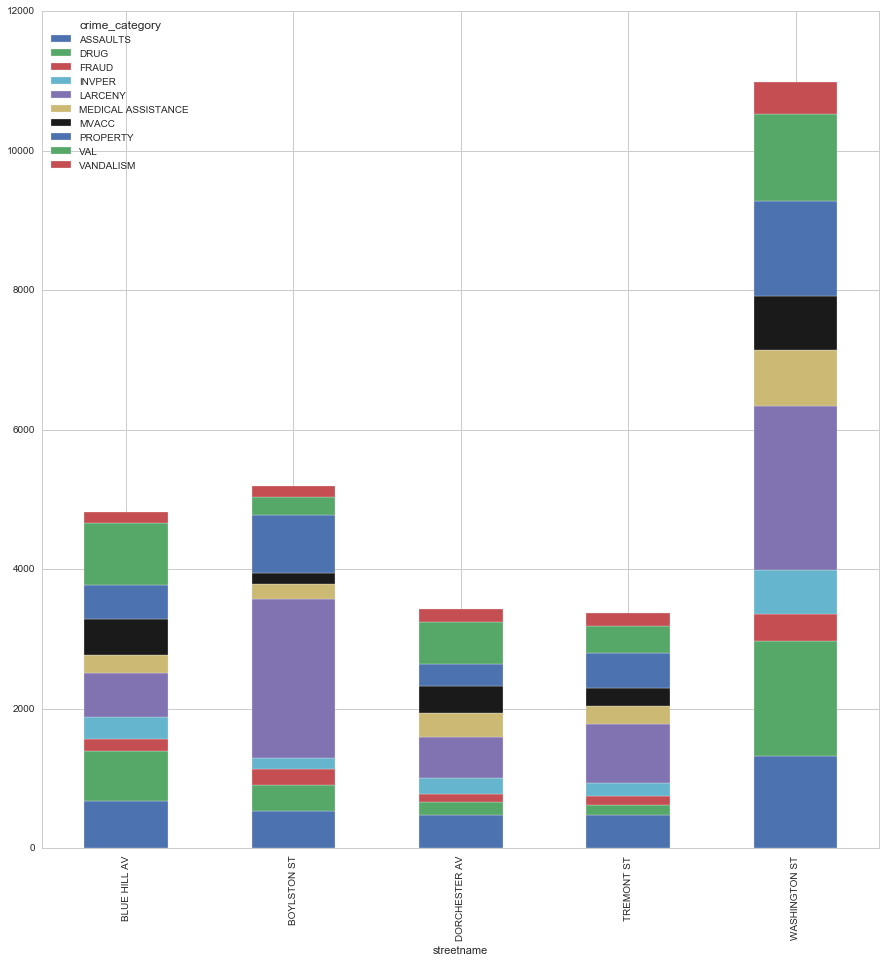

In [236]:
fig, axes = plt.subplots(1,1,figsize=(15,15))
tmp.plot(ax=axes,kind='bar', stacked=True)

#### Boston Marathon Bombings?

In [238]:
df_boylston = df_boston.query('streetname == "BOYLSTON ST"')

In [244]:
df_boylston_bomb = df_boylston.query('dates == "04/15/2013"')

In [247]:
df_boylston_bomb.crime_category.value_counts()

PROPERTY              98
MEDICAL ASSISTANCE    17
ASSAULTS               3
INVESTIGATION          3
LARCENY                2
FIRE                   1
Name: crime_category, dtype: int64

We can see the effect of Boston Marathon Bombings on Boylston Street - the epicentre of the bombings. 98 incidents are related to property related crimes and there seem to be some medical assistance related incidents too.

#### Effect of Boston Marathon on crime related incidents over the years:

In [250]:
df_boston_marathon = df_boston.query('dates == "04/15/2013" or dates == "04/16/2012" or dates == "04/21/2014" or dates == "04/20/2015"')

In [252]:
df_boston_marathon.crime_category.value_counts()[:5]

PROPERTY              189
LARCENY                99
ASSAULTS               67
MEDICAL ASSISTANCE     62
VAL                    59
Name: crime_category, dtype: int64

There has been a high amount of Medical Assistance and Property related incidents - both make sense in the case of an event like 
Boston Marathon.

#### Effect of Boston July 4 event on crime related incidents over the years

In [254]:
df_boston_marathon = df_boston.query('dates == "07/04/2013" or dates == "07/04/2012" or dates == "07/04/2014" or dates == "07/04/2015"')

In [255]:
df_boston_marathon.crime_category.value_counts()[:5]

LARCENY               114
ASSAULTS               93
PROPERTY               69
VAL                    56
MEDICAL ASSISTANCE     49
Name: crime_category, dtype: int64

A high number of Larceny related incidents are recorded - reasonable in the case of a big event like the July 4 Parade.

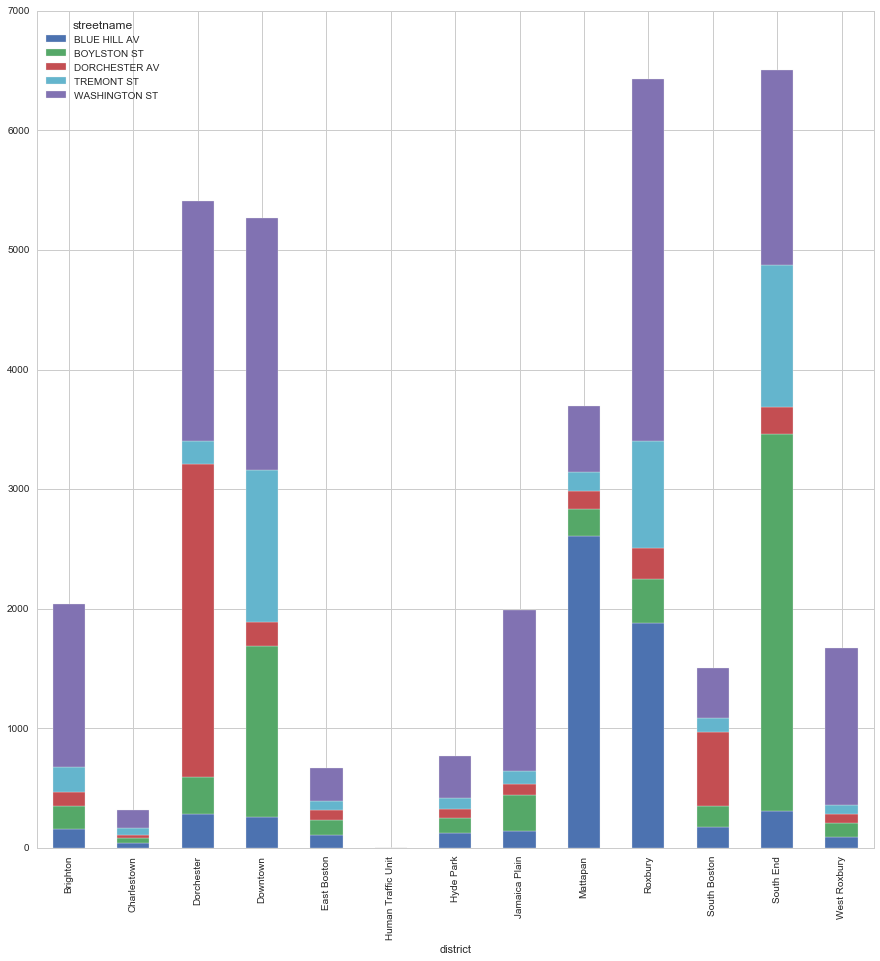

In [258]:
df_streetname=pd.DataFrame(df_boston.streetname.value_counts())
df_streetname_head = pd.Series(df_streetname.head(5).index)
df_streetname_head_10 = df_boston[df_boston['streetname'].isin(df_streetname_head)]

tmp=pd.DataFrame(df_streetname_head_10.groupby(['district','streetname']).size(), columns=['count'])
tmp.reset_index(inplace=True)
tmp=tmp.pivot(index='district',columns='streetname',values='count')
fig, axes = plt.subplots(1,1,figsize=(15,15))
tmp.plot(ax=axes,kind='bar', stacked=True)

In [287]:
list_lattitudes = list()
list_longitudes = list()
for loc in df_boston.location.value_counts().index:
    list_lattitudes.append(float(loc.strip('()').split(',')[0]))
    list_longitudes.append(float(loc.strip('()').split(',')[1]))

In [290]:
df_boston['latitudes'] = pd.Series(list_lattitudes)
df_boston['longitudes'] = pd.Series(list_longitudes)

In [303]:
df_boston.fillna(0.0);
df_boston = df_boston[df_boston.latitudes != 0.0]
df_boston = df_boston[df_boston.longitudes != 0.0]

-71.1786737831 -70.9643648945
42.23226359 42.3951052441


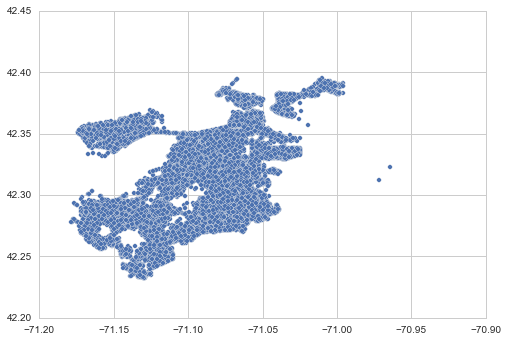

In [304]:
plt.scatter(df_boston.longitudes, df_boston.latitudes)
print df_boston.longitudes.min(), df_boston.longitudes.max()
print df_boston.latitudes.min(), df_boston.latitudes.max()

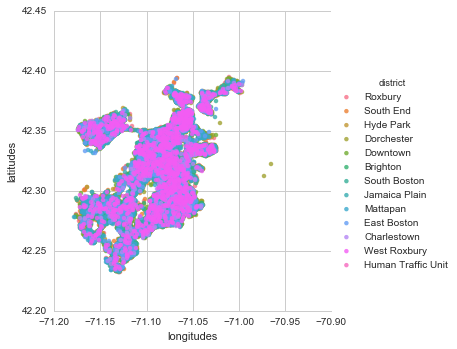

In [307]:
sns.lmplot('longitudes', 'latitudes', data=df_boston, hue='district', fit_reg=False)